# Simulating a dynamic recommendation setting

In [1]:
import numpy as np
import pandas as pd
import sys
import pickle

import torch
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

sys.path.append('..')

from simulationConstants import ML_1M_FILLED_PATH, ML_1M_FILLED_PATH_PKL, ML_1M_ORACLE_PATH

In [2]:
synthetic_data_matrix = pd.read_csv(f"../{ML_1M_FILLED_PATH}")

In [3]:
synthetic_data_matrix

,user,item,clicked_and_examined,clicked_at,timestamp
0,1,1825,0.0,NaN,NaN
1,1,3666,0.0,NaN,NaN
2,1,1499,0.0,NaN,NaN
3,1,3876,0.0,NaN,NaN
4,1,12,NaN,NaN,NaN
...,...,...,...,...,...
1057795,6040,1286,NaN,NaN,NaN
1057796,6040,2163,NaN,NaN,NaN
1057797,6040,2118,NaN,NaN,NaN
1057798,6040,2658,0.0,NaN,NaN


In [4]:
len(synthetic_data_matrix["user"].drop_duplicates())

5289

In [5]:
feedback = synthetic_data_matrix.rename(columns={"clicked_and_examined": "relevant", "clicked_at": "click"})

In [6]:
initial_date = feedback["timestamp"].max()

In [7]:
movielensOraclePreferenceMatrix = pd.read_csv(f"../{ML_1M_ORACLE_PATH}").drop(columns=["Unnamed: 0"])

In [8]:
movielensOraclePreferenceMatrix

,user,item,genres,rating
0,1,1193,drama,1
1,1,661,animation|children's|musical,0
2,1,914,musical|romance,0
3,1,3408,drama,1
4,1,2355,animation|children's|comedy,1
...,...,...,...,...
19574584,6040,2258,action,0
19574585,6040,2845,drama,0
19574586,6040,3607,comedy|drama|western,1
19574587,6040,690,romance,0


## Simulation process

To simulate users, we'll: 

1. Retain 1000 random users from our synbtethic_data_matrix
2. For each k iteration in the simulation:
    3. Recommend 20 items to the user
        a. For calibration: we recommend 100 but calibrate to 20. This is done to increase recall before running the reranking
    4. Log the clicks 
5. Every 50 iteractions, retrain the recommender
6. Run this for 10_000 iteractions

In [9]:
from simulationUtils import get_user_feedback_for_item

In [10]:
with open('userToExpDistribution.pkl', 'rb') as f:
    movielensUserToExpDistribution = pickle.load(f)

In [11]:
initial_date = None

In [12]:
unique_users = list(feedback["user"].drop_duplicates())

In [13]:
if initial_date is None:
    initial_date = pd.Timestamp.now().timestamp()
user_to_up_to_date_timestamp = pd.DataFrame({
    "user": unique_users, 
    "delta_from_start": 0.0
})
user_to_up_to_date_timestamp["timestamp_dist"] = user_to_up_to_date_timestamp["user"].map(movielensUserToExpDistribution)

In [14]:
def map_recommendation_to_feedback(user, rec_list, matrix, userToExpDistribution):
    results = []
    max_delta = 0
    for idx, item in enumerate(rec_list):
        user, item, feedback, clicked_at, delta  = get_user_feedback_for_item(user, item, idx+1, matrix, userToExpDistribution)
        if (delta is not None and delta > max_delta):
            max_delta = delta
        feedback = (user, item, feedback, clicked_at, delta)
        results.append(feedback)
    return results, max_delta

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
sys.path.append('/home/caio/dev/bprMf')

In [17]:
from bpr_mf import bprMFLClickDebiasingDataloader, bprMF, bpr_train_with_debiasing, bpr_loss_with_reg_with_debiased_click
from utils import generate_bpr_dataset_with_click_data

In [18]:
bpr_dataset = generate_bpr_dataset_with_click_data(feedback, num_negatives=5)

In [19]:
bpr_dataset

,user,pos_item,click_position,neg_item
0,3,3408,6,1268
1,3,3408,6,2998
2,3,3408,6,2705
3,3,3408,6,3683
4,3,3408,6,1018
...,...,...,...,...
603525,6040,2300,9,2685
603526,6040,2300,9,19
603527,6040,2300,9,3052
603528,6040,2300,9,2438


In [20]:
n_users = bpr_dataset["user"].max() + 1
n_items = bpr_dataset.pos_item.max() + 1


In [21]:
n_users, n_items

(6041, 3953)

In [22]:
def train(model, data, train_ratio=0.8, debug=False):

    bpr_dataset = generate_bpr_dataset_with_click_data(data, num_negatives=5)
    data_bpr = bprMFLClickDebiasingDataloader(bpr_dataset)


    train_len = int(train_ratio * len(data_bpr))
    test_len = len(data_bpr) - train_len


    train_data, test_data = random_split(data_bpr, [train_len, test_len])



    dataloader_bpr_train = DataLoader(train_data, batch_size=256, shuffle=True)
    dataloader_bpr_test = DataLoader(test_data, batch_size=256, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


    _, _ = bpr_train_with_debiasing(
        train_data_loader=dataloader_bpr_train,
        test_data_loader=dataloader_bpr_test,
        model=model,
        bpr_loss=bpr_loss_with_reg_with_debiased_click,
        optimizer=optimizer,
        reg_lambda=5e-4,
        debug=debug
    )

    return model

In [23]:
sys.path.append("/home/caio/dev/calibratedRecs")
sys.path.append("/home/caio/dev/calibratedRecs/constants.py")


In [24]:
from calibrationUtils import preprocess_genres

In [25]:

from constants import ITEM_COL, GENRE_COL, USER_COL

In [26]:
with open(f"../data/simulation/movielens_1m_sample_sinthetically_filled.pkl", "rb") as f:
    ml_filled = preprocess_genres(pickle.load(f).drop_duplicates())



In [27]:

ml_item_to_genre = (
    ml_filled[[ITEM_COL, GENRE_COL]]
    .set_index(ITEM_COL)[GENRE_COL]
    .to_dict()
)

In [28]:
from simulationUtils import simulate_user_feedback, get_candidate_items

In [29]:
from metrics import mace

In [47]:


def simulate(
    D, 
    model, 
    unique_users, 
    unique_items, 
    oracleMatrix, 
    userToExpDistribution, 
    item2genreMap, 
    k=100, 
    rounds=1000, 
    L=10, 
    initial_date=None
):
    """
    Simulates a dynamic recommendation setting.

    Parameters
    ----------
    D : pd.DataFrame
        Initial feedback data containing user-item interactions.
    model : torch.nn.Module
        Recommendation model with a predict_flat method.
    unique_users : list
        List of unique user IDs to simulate.
    unique_items : list
        List of unique item IDs to recommend.
    oracleMatrix : pd.DataFrame
        Matrix containing oracle user preferences for items.
    userToExpDistribution : dict
        Mapping from user ID to their timestamp distribution.
    item2genreMap : dict
        Mapping from item ID to its genres.
    k : int, optional
        Number of items to recommend per user per round (default=100).
    rounds : int, optional
        Number of simulation rounds (default=1000).
    L : int, optional
        Retrain model every L rounds (default=10).
    initial_date : float, optional
        Initial timestamp for simulation (default=None).

    Returns
    -------
    final_df : pd.DataFrame
        DataFrame containing all simulated feedback.
    maces : list
        List of MACE metric values computed every L rounds.
    """

    # Setup initial data
    user2history = D.groupby(USER_COL).agg({ITEM_COL: list}).to_dict()[ITEM_COL]

    if initial_date is None:
        initial_date = pd.Timestamp.now().timestamp()
    user_to_up_to_date_timestamp = pd.DataFrame({
        "user": unique_users,
        "delta_from_start": 0.0
    })
    maces = []
    user_to_up_to_date_timestamp["timestamp_dist"] = user_to_up_to_date_timestamp["user"].map(userToExpDistribution)
    new_df = D.copy()
    for round in range(1, rounds + 1):
        print(f"Starting round {round} / {rounds}")
        rows_to_append = []
        for user in tqdm(unique_users, desc="Users"):
            candidate_items = torch.tensor(get_candidate_items(user, D, unique_items), device=device)
            row, user_to_up_to_date_timestamp = simulate_user_feedback(
            user=user,
            candidate_items=candidate_items,
            preference_matrix=oracleMatrix,
            recommend=model.predict_flat,
            k=k,
            user_to_up_to_date_timestamp=user_to_up_to_date_timestamp,
            userToExpDistribution=movielensUserToExpDistribution
            )
            rows_to_append.extend(row)
        recommendation_df = pd.DataFrame(rows_to_append, columns=new_df.columns)
        if (round % L == 0):
            print("retraining model...")
            model = train(model, new_df)
            print("Calculating mace")
            rec_df_grouped = recommendation_df.groupby(USER_COL).agg({ITEM_COL: list}).reset_index().rename(columns={ITEM_COL: "rec"})
            iteration_mace = mace(df=rec_df_grouped, user2history=user2history, recCol='rec', item2genreMap=item2genreMap)
            maces.append(iteration_mace)
        if (round % 100 == 0):
            recommendation_df.to_csv(f"data/movielens/no_calibration_sim_up_to_round_{round}")
        new_df = pd.concat([new_df, recommendation_df], ignore_index=True)
    final_df = pd.concat([D, new_df])
    final_df.loc[final_df["timestamp"].notnull(), "timestamp"] += initial_date
    return final_df, maces

In [37]:
unique_items = list(feedback["item"].unique())
unique_users = list(feedback["user"].unique())

In [45]:
sampled_users = np.random.choice(unique_users, size=500, replace=False)

In [42]:
model = bprMF(num_users=n_users, num_items=n_items, factors=30).to(device)
model = train(model, feedback)

In [48]:
feedback_final, maces = simulate(
    D=feedback,
    model=model,
    unique_users=sampled_users,
    unique_items=unique_items,
    oracleMatrix=movielensOraclePreferenceMatrix,
    userToExpDistribution=movielensUserToExpDistribution,
    k=100,
    rounds=500,
    L=5,
    initial_date=0.0,
    item2genreMap=ml_item_to_genre
)

Starting round 1 / 500


Users: 100%|██████████| 500/500 [06:21<00:00,  1.31it/s]


Starting round 2 / 500


Users: 100%|██████████| 500/500 [06:13<00:00,  1.34it/s]


Starting round 3 / 500


Users: 100%|██████████| 500/500 [06:11<00:00,  1.35it/s]


Starting round 4 / 500


Users: 100%|██████████| 500/500 [06:18<00:00,  1.32it/s]


Starting round 5 / 500


Users: 100%|██████████| 500/500 [06:21<00:00,  1.31it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 314.51it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 314.30it/s]


Starting round 6 / 500


Users: 100%|██████████| 500/500 [06:18<00:00,  1.32it/s]


Starting round 7 / 500


Users: 100%|██████████| 500/500 [06:21<00:00,  1.31it/s]


Starting round 8 / 500


Users: 100%|██████████| 500/500 [06:16<00:00,  1.33it/s]


Starting round 9 / 500


Users: 100%|██████████| 500/500 [06:15<00:00,  1.33it/s]


Starting round 10 / 500


Users: 100%|██████████| 500/500 [06:14<00:00,  1.33it/s]


retraining model...
Calculating mace


 45%|████▍     | 224/500 [00:00<00:00, 316.25it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 314.37it/s]


Starting round 11 / 500


Users: 100%|██████████| 500/500 [06:08<00:00,  1.36it/s]


Starting round 12 / 500


Users: 100%|██████████| 500/500 [06:17<00:00,  1.33it/s]


Starting round 13 / 500


Users: 100%|██████████| 500/500 [06:14<00:00,  1.33it/s]


Starting round 14 / 500


Users: 100%|██████████| 500/500 [06:13<00:00,  1.34it/s]


Starting round 15 / 500


Users: 100%|██████████| 500/500 [06:12<00:00,  1.34it/s]


retraining model...
Calculating mace


 77%|███████▋  | 385/500 [00:01<00:00, 316.68it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 313.94it/s]


Starting round 16 / 500


Users: 100%|██████████| 500/500 [06:16<00:00,  1.33it/s]


Starting round 17 / 500


Users: 100%|██████████| 500/500 [06:03<00:00,  1.37it/s]


Starting round 18 / 500


Users: 100%|██████████| 500/500 [06:18<00:00,  1.32it/s]


Starting round 19 / 500


Users: 100%|██████████| 500/500 [06:09<00:00,  1.35it/s]


Starting round 20 / 500


Users: 100%|██████████| 500/500 [06:08<00:00,  1.36it/s]


retraining model...
Calculating mace


 78%|███████▊  | 391/500 [00:01<00:00, 317.62it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 318.82it/s]


Starting round 21 / 500


Users: 100%|██████████| 500/500 [06:05<00:00,  1.37it/s]


Starting round 22 / 500


Users: 100%|██████████| 500/500 [06:10<00:00,  1.35it/s]


Starting round 23 / 500


Users: 100%|██████████| 500/500 [06:07<00:00,  1.36it/s]


Starting round 24 / 500


Users: 100%|██████████| 500/500 [06:06<00:00,  1.37it/s]


Starting round 25 / 500


Users: 100%|██████████| 500/500 [06:08<00:00,  1.36it/s]


retraining model...
Calculating mace


 77%|███████▋  | 387/500 [00:01<00:00, 316.37it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 316.12it/s]


Starting round 26 / 500


Users: 100%|██████████| 500/500 [06:11<00:00,  1.35it/s]


Starting round 27 / 500


Users: 100%|██████████| 500/500 [06:15<00:00,  1.33it/s]


Starting round 28 / 500


Users: 100%|██████████| 500/500 [06:15<00:00,  1.33it/s]


Starting round 29 / 500


Users: 100%|██████████| 500/500 [06:14<00:00,  1.34it/s]


Starting round 30 / 500


Users: 100%|██████████| 500/500 [06:16<00:00,  1.33it/s]


retraining model...
Calculating mace


 78%|███████▊  | 389/500 [00:01<00:00, 318.09it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 317.40it/s]


Starting round 31 / 500


Users: 100%|██████████| 500/500 [06:14<00:00,  1.34it/s]


Starting round 32 / 500


Users: 100%|██████████| 500/500 [06:18<00:00,  1.32it/s]


Starting round 33 / 500


Users: 100%|██████████| 500/500 [06:15<00:00,  1.33it/s]


Starting round 34 / 500


Users: 100%|██████████| 500/500 [06:13<00:00,  1.34it/s]


Starting round 35 / 500


Users: 100%|██████████| 500/500 [06:16<00:00,  1.33it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 324.36it/s]


Starting round 36 / 500


Users: 100%|██████████| 500/500 [06:14<00:00,  1.34it/s]


Starting round 37 / 500


Users: 100%|██████████| 500/500 [06:27<00:00,  1.29it/s]


Starting round 38 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 39 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 40 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


retraining model...
Calculating mace


 89%|████████▊ | 443/500 [00:01<00:00, 310.30it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 309.64it/s]


Starting round 41 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 42 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 43 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 44 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 45 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.89it/s]


Starting round 46 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 47 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 48 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 49 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 50 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


retraining model...
Calculating mace


 77%|███████▋  | 383/500 [00:01<00:00, 313.56it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 312.10it/s]


Starting round 51 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 52 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 53 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 54 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 55 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


 70%|███████   | 352/500 [00:01<00:00, 312.83it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.90it/s]


Starting round 56 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 57 / 500


Users: 100%|██████████| 500/500 [06:26<00:00,  1.29it/s]


Starting round 58 / 500


Users: 100%|██████████| 500/500 [06:23<00:00,  1.30it/s]


Starting round 59 / 500


Users: 100%|██████████| 500/500 [06:27<00:00,  1.29it/s]


Starting round 60 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


retraining model...
Calculating mace


 45%|████▍     | 223/500 [00:00<00:00, 311.35it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.29it/s]


Starting round 61 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 62 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 63 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 64 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 65 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 304.56it/s]


Starting round 66 / 500


Users: 100%|██████████| 500/500 [07:43<00:00,  1.08it/s]


Starting round 67 / 500


Users: 100%|██████████| 500/500 [07:46<00:00,  1.07it/s]


Starting round 68 / 500


Users: 100%|██████████| 500/500 [07:54<00:00,  1.05it/s]


Starting round 69 / 500


Users: 100%|██████████| 500/500 [07:41<00:00,  1.08it/s]


Starting round 70 / 500


Users: 100%|██████████| 500/500 [07:54<00:00,  1.05it/s]


retraining model...
Calculating mace


 67%|██████▋   | 333/500 [00:01<00:00, 298.40it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 296.86it/s]


Starting round 71 / 500


Users: 100%|██████████| 500/500 [07:43<00:00,  1.08it/s]


Starting round 72 / 500


Users: 100%|██████████| 500/500 [07:50<00:00,  1.06it/s]


Starting round 73 / 500


Users: 100%|██████████| 500/500 [07:56<00:00,  1.05it/s]


Starting round 74 / 500


Users: 100%|██████████| 500/500 [08:25<00:00,  1.01s/it]


Starting round 75 / 500


Users: 100%|██████████| 500/500 [08:29<00:00,  1.02s/it]


retraining model...
Calculating mace


 66%|██████▌   | 330/500 [00:01<00:00, 294.33it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 291.89it/s]


Starting round 76 / 500


Users: 100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


Starting round 77 / 500


Users: 100%|██████████| 500/500 [08:16<00:00,  1.01it/s]


Starting round 78 / 500


Users: 100%|██████████| 500/500 [06:59<00:00,  1.19it/s]


Starting round 79 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 80 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 310.60it/s]


Starting round 81 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 82 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 83 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 84 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 85 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.01it/s]


Starting round 86 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 87 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 88 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 89 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 90 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


retraining model...
Calculating mace


 77%|███████▋  | 383/500 [00:01<00:00, 312.49it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 312.07it/s]


Starting round 91 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 92 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 93 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 94 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 95 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 309.22it/s]


Starting round 96 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 97 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 98 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 99 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 100 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.87it/s]


Starting round 101 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 102 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 103 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 104 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 105 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


retraining model...
Calculating mace


 77%|███████▋  | 383/500 [00:01<00:00, 306.04it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 308.76it/s]


Starting round 106 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 107 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 108 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.27it/s]


Starting round 109 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 110 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 310.18it/s]


Starting round 111 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 112 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 113 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.29it/s]


Starting round 114 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 115 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 310.39it/s]


Starting round 116 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 117 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 118 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 119 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 120 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 311.95it/s]


Starting round 121 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 122 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 123 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 124 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 125 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


 45%|████▍     | 224/500 [00:00<00:00, 310.99it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.59it/s]


Starting round 126 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 127 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 128 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 129 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 130 / 500


Users: 100%|██████████| 500/500 [06:43<00:00,  1.24it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 309.15it/s]


Starting round 131 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 132 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 133 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 134 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 135 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


retraining model...
Calculating mace


 51%|█████     | 254/500 [00:00<00:00, 310.40it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 310.47it/s]


Starting round 136 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 137 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 138 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 139 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 140 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


retraining model...
Calculating mace


 77%|███████▋  | 383/500 [00:01<00:00, 311.75it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 309.52it/s]


Starting round 141 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 142 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 143 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 144 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 145 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 311.14it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 307.65it/s]


Starting round 146 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 147 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.26it/s]


Starting round 148 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 149 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 150 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 307.98it/s]


Starting round 151 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 152 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 153 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 154 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 155 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


retraining model...
Calculating mace


 77%|███████▋  | 383/500 [00:01<00:00, 308.71it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 310.21it/s]


Starting round 156 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 157 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 158 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 159 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 160 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 311.59it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 310.94it/s]


Starting round 161 / 500


Users: 100%|██████████| 500/500 [06:41<00:00,  1.24it/s]


Starting round 162 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Starting round 163 / 500


Users: 100%|██████████| 500/500 [06:41<00:00,  1.25it/s]


Starting round 164 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.26it/s]


Starting round 165 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.26it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 308.12it/s]


Starting round 166 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.26it/s]


Starting round 167 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Starting round 168 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 169 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 170 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.26it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 312.77it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.34it/s]


Starting round 171 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 172 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 173 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Starting round 174 / 500


Users: 100%|██████████| 500/500 [06:42<00:00,  1.24it/s]


Starting round 175 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


retraining model...
Calculating mace


 76%|███████▌  | 381/500 [00:01<00:00, 312.75it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.21it/s]


Starting round 176 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 177 / 500


Users: 100%|██████████| 500/500 [06:43<00:00,  1.24it/s]


Starting round 178 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.26it/s]


Starting round 179 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 180 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 313.32it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 312.28it/s]


Starting round 181 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 182 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Starting round 183 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Starting round 184 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Starting round 185 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 311.30it/s]


Starting round 186 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 187 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 188 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 189 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.27it/s]


Starting round 190 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


 77%|███████▋  | 383/500 [00:01<00:00, 312.20it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.71it/s]


Starting round 191 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 192 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 193 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 194 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 195 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


retraining model...
Calculating mace


 70%|███████   | 351/500 [00:01<00:00, 312.73it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.80it/s]


Starting round 196 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.26it/s]


Starting round 197 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


Starting round 198 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 199 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 200 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 307.83it/s]


Starting round 201 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 202 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 203 / 500


Users: 100%|██████████| 500/500 [06:41<00:00,  1.25it/s]


Starting round 204 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 205 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 311.19it/s]


Starting round 206 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 207 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 208 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 209 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 210 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


retraining model...
Calculating mace


 70%|███████   | 352/500 [00:01<00:00, 313.37it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 312.45it/s]


Starting round 211 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 212 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 213 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 214 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 215 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 311.28it/s]


Starting round 216 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 217 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 218 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 219 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 220 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 311.12it/s]


Starting round 221 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 222 / 500


Users: 100%|██████████| 500/500 [06:42<00:00,  1.24it/s]


Starting round 223 / 500


Users: 100%|██████████| 500/500 [06:45<00:00,  1.23it/s]


Starting round 224 / 500


Users: 100%|██████████| 500/500 [07:28<00:00,  1.12it/s]


Starting round 225 / 500


Users: 100%|██████████| 500/500 [07:47<00:00,  1.07it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 296.92it/s]


Starting round 226 / 500


Users: 100%|██████████| 500/500 [07:42<00:00,  1.08it/s]


Starting round 227 / 500


Users: 100%|██████████| 500/500 [07:52<00:00,  1.06it/s]


Starting round 228 / 500


Users: 100%|██████████| 500/500 [08:11<00:00,  1.02it/s]


Starting round 229 / 500


Users: 100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


Starting round 230 / 500


Users: 100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 311.96it/s]


Starting round 231 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 232 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 233 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 234 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 235 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.48it/s]


Starting round 236 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 237 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 238 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 239 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 240 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 310.79it/s]


Starting round 241 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 242 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 243 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


Starting round 244 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 245 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.83it/s]


Starting round 246 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 247 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 248 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 249 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 250 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 310.44it/s]


Starting round 251 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 252 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 253 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 254 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 255 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


retraining model...
Calculating mace


 75%|███████▌  | 375/500 [00:01<00:00, 309.67it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 308.65it/s]


Starting round 256 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 257 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 258 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 259 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 260 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 312.07it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.88it/s]


Starting round 261 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 262 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


Starting round 263 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.26it/s]


Starting round 264 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Starting round 265 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 312.01it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 312.49it/s]


Starting round 266 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 267 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 268 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 269 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 270 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


retraining model...
Calculating mace


 45%|████▍     | 224/500 [00:00<00:00, 311.23it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.50it/s]


Starting round 271 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 272 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 273 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 274 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 275 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.96it/s]


Starting round 276 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 277 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 278 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 279 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 280 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.26it/s]


Starting round 281 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 282 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 283 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


Starting round 284 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 285 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 311.58it/s]


Starting round 286 / 500


Users: 100%|██████████| 500/500 [06:27<00:00,  1.29it/s]


Starting round 287 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 288 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 289 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 290 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 311.00it/s]


Starting round 291 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 292 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 293 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 294 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 295 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 314.29it/s]


Starting round 296 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 297 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 298 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 299 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 300 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 312.89it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 312.38it/s]


Starting round 301 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 302 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.28it/s]


Starting round 303 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 304 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.27it/s]


Starting round 305 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 312.39it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.72it/s]


Starting round 306 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 307 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 308 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 309 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 310 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


retraining model...
Calculating mace


 77%|███████▋  | 385/500 [00:01<00:00, 312.94it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 314.23it/s]


Starting round 311 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 312 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 313 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 314 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 315 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 310.96it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.24it/s]


Starting round 316 / 500


Users: 100%|██████████| 500/500 [06:42<00:00,  1.24it/s]


Starting round 317 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 318 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


Starting round 319 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 320 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 311.27it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 312.82it/s]


Starting round 321 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 322 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 323 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


Starting round 324 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Starting round 325 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 311.36it/s]


Starting round 326 / 500


Users: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Starting round 327 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 328 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 329 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 330 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.10it/s]


Starting round 331 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 332 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 333 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 334 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 335 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.41it/s]


Starting round 336 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 337 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 338 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 339 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 340 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.47it/s]


Starting round 341 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 342 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 343 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 344 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 345 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 314.67it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 313.70it/s]


Starting round 346 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 347 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 348 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 349 / 500


Users: 100%|██████████| 500/500 [08:07<00:00,  1.03it/s]


Starting round 350 / 500


Users: 100%|██████████| 500/500 [07:34<00:00,  1.10it/s]


retraining model...
Calculating mace


 75%|███████▍  | 373/500 [00:01<00:00, 273.76it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 277.74it/s]


Starting round 351 / 500


Users: 100%|██████████| 500/500 [07:50<00:00,  1.06it/s]


Starting round 352 / 500


Users: 100%|██████████| 500/500 [07:29<00:00,  1.11it/s]


Starting round 353 / 500


Users: 100%|██████████| 500/500 [07:39<00:00,  1.09it/s]


Starting round 354 / 500


Users: 100%|██████████| 500/500 [07:07<00:00,  1.17it/s]


Starting round 355 / 500


Users: 100%|██████████| 500/500 [07:08<00:00,  1.17it/s]


retraining model...
Calculating mace


 75%|███████▍  | 374/500 [00:01<00:00, 280.08it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 261.01it/s]


Starting round 356 / 500


Users: 100%|██████████| 500/500 [07:57<00:00,  1.05it/s]


Starting round 357 / 500


Users: 100%|██████████| 500/500 [07:46<00:00,  1.07it/s]


Starting round 358 / 500


Users: 100%|██████████| 500/500 [07:49<00:00,  1.07it/s]


Starting round 359 / 500


Users: 100%|██████████| 500/500 [07:52<00:00,  1.06it/s]


Starting round 360 / 500


Users: 100%|██████████| 500/500 [07:45<00:00,  1.07it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.60it/s]


Starting round 361 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 362 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 363 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


Starting round 364 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 365 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 310.33it/s]


Starting round 366 / 500


Users: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Starting round 367 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 368 / 500


Users: 100%|██████████| 500/500 [06:43<00:00,  1.24it/s]


Starting round 369 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 370 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 313.57it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 313.27it/s]


Starting round 371 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 372 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 373 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.28it/s]


Starting round 374 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 375 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 314.64it/s]


Starting round 376 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 377 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 378 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 379 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 380 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 312.33it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 312.96it/s]


Starting round 381 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 382 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 383 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 384 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.28it/s]


Starting round 385 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.33it/s]


Starting round 386 / 500


Users: 100%|██████████| 500/500 [06:25<00:00,  1.30it/s]


Starting round 387 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 388 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 389 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 390 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


 77%|███████▋  | 383/500 [00:01<00:00, 314.09it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 313.58it/s]


Starting round 391 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 392 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 393 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 394 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 395 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.78it/s]


Starting round 396 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 397 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 398 / 500


Users: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Starting round 399 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 400 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.27it/s]


Starting round 401 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 402 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 403 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 404 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 405 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 311.65it/s]


Starting round 406 / 500


Users: 100%|██████████| 500/500 [06:42<00:00,  1.24it/s]


Starting round 407 / 500


Users: 100%|██████████| 500/500 [06:47<00:00,  1.23it/s]


Starting round 408 / 500


Users: 100%|██████████| 500/500 [06:43<00:00,  1.24it/s]


Starting round 409 / 500


Users: 100%|██████████| 500/500 [06:42<00:00,  1.24it/s]


Starting round 410 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.05it/s]


Starting round 411 / 500


Users: 100%|██████████| 500/500 [06:43<00:00,  1.24it/s]


Starting round 412 / 500


Users: 100%|██████████| 500/500 [06:44<00:00,  1.24it/s]


Starting round 413 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 414 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 415 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 313.41it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 313.49it/s]


Starting round 416 / 500


Users: 100%|██████████| 500/500 [06:44<00:00,  1.24it/s]


Starting round 417 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 418 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.27it/s]


Starting round 419 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.28it/s]


Starting round 420 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 314.90it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 314.18it/s]


Starting round 421 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 422 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 423 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 424 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 425 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 314.72it/s]


Starting round 426 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 427 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 428 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 429 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 430 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.62it/s]


Starting round 431 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 432 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 433 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 434 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 435 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


retraining model...
Calculating mace


 79%|███████▉  | 394/500 [00:01<00:00, 291.34it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 288.69it/s]


Starting round 436 / 500


Users: 100%|██████████| 500/500 [07:26<00:00,  1.12it/s]


Starting round 437 / 500


Users: 100%|██████████| 500/500 [07:34<00:00,  1.10it/s]


Starting round 438 / 500


Users: 100%|██████████| 500/500 [07:53<00:00,  1.05it/s]


Starting round 439 / 500


Users: 100%|██████████| 500/500 [07:33<00:00,  1.10it/s]


Starting round 440 / 500


Users: 100%|██████████| 500/500 [07:34<00:00,  1.10it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.62it/s]


Starting round 441 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 442 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 443 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 444 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 445 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.57it/s]


Starting round 446 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.27it/s]


Starting round 447 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 448 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 449 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 450 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.36it/s]


Starting round 451 / 500


Users: 100%|██████████| 500/500 [06:27<00:00,  1.29it/s]


Starting round 452 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 453 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 454 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 455 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


retraining model...
Calculating mace


 45%|████▍     | 224/500 [00:00<00:00, 315.25it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 313.39it/s]


Starting round 456 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 457 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 458 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 459 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 460 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.77it/s]


Starting round 461 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 462 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 463 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 464 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 465 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 314.31it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 313.79it/s]


Starting round 466 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 467 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 468 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 469 / 500


Users: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


Starting round 470 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 314.68it/s]


Starting round 471 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 472 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 473 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 474 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 475 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 315.07it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 313.66it/s]


Starting round 476 / 500


Users: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


Starting round 477 / 500


Users: 100%|██████████| 500/500 [07:15<00:00,  1.15it/s]


Starting round 478 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Starting round 479 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 480 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 305.16it/s]


Starting round 481 / 500


Users: 100%|██████████| 500/500 [07:48<00:00,  1.07it/s]


Starting round 482 / 500


Users: 100%|██████████| 500/500 [07:47<00:00,  1.07it/s]


Starting round 483 / 500


Users: 100%|██████████| 500/500 [08:11<00:00,  1.02it/s]


Starting round 484 / 500


Users: 100%|██████████| 500/500 [07:52<00:00,  1.06it/s]


Starting round 485 / 500


Users: 100%|██████████| 500/500 [07:02<00:00,  1.18it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 312.70it/s]


Starting round 486 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 487 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 488 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 489 / 500


Users: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Starting round 490 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


retraining model...
Calculating mace


100%|██████████| 500/500 [00:01<00:00, 313.25it/s]


Starting round 491 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 492 / 500


Users: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


Starting round 493 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 494 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


Starting round 495 / 500


Users: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


retraining model...
Calculating mace


 76%|███████▋  | 382/500 [00:01<00:00, 311.44it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 311.33it/s]


Starting round 496 / 500


Users: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


Starting round 497 / 500


Users: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


Starting round 498 / 500


Users: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


Starting round 499 / 500


Users: 100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


Starting round 500 / 500


Users: 100%|██████████| 500/500 [06:35<00:00,  1.27it/s]


retraining model...
Calculating mace


 77%|███████▋  | 384/500 [00:01<00:00, 313.06it/s]/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caio/dev/tasteDistortionOnDynamicRecs/.dynamicTaste/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [00:01<00:00, 313.51it/s]


In [50]:
maces

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.043994188557327625,
 nan,
 0.043450001625031355,
 nan,
 nan,
 nan,
 0.04446884514626176,
 nan,
 nan,
 0.044248433504732856,
 0.043729879817384895,
 nan,
 0.04374346093008863,
 0.04415712111262238,
 nan,
 0.04381190783158209,
 0.04393763280159823,
 0.044357225483473324,
 nan,
 0.04388733198565487,
 nan,
 nan,
 nan,
 0.044181314048169926,
 nan,
 nan,
 0.04425268349245217,
 nan,
 nan,
 nan,
 0.04445321751109571,
 nan,
 nan,
 0.044081348929414614,
 0.04436327641499725,
 nan,
 0.04366431830496874,
 0.0442759852346967,
 0.044248419367337415,
 0.04391820870295803,
 0.04447588660578367,
 0.044272241837348285,
 0.04435791389998554,
 0.0442710426598391,
 nan,
 nan,
 nan,
 nan,
 0.04441461736195163,
 0.04417797585876205,
 0.04453499212734264,
 0.04415397927755038,
 0.04398497164666458,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.04506142417405427,
 0.04441462070359363,
 0.04443316203466446,
 0.04465984124895786,
 nan,
 nan,
 nan,
 0.04441196525684184,
 0.04426521360564

In [52]:
from matplotlib import pyplot as plt

In [55]:
feedback

,user,item,relevant,click,timestamp
0,1,1825,0.0,NaN,NaN
1,1,3666,0.0,NaN,NaN
2,1,1499,0.0,NaN,NaN
3,1,3876,0.0,NaN,NaN
4,1,12,NaN,NaN,NaN
...,...,...,...,...,...
1057795,6040,1286,NaN,NaN,NaN
1057796,6040,2163,NaN,NaN,NaN
1057797,6040,2118,NaN,NaN,NaN
1057798,6040,2658,0.0,NaN,NaN


In [54]:
feedback_final

,user,item,relevant,click,timestamp
0,1,1825,0.0,NaN,NaN
1,1,3666,0.0,NaN,NaN
2,1,1499,0.0,NaN,NaN
3,1,3876,0.0,NaN,NaN
4,1,12,NaN,NaN,NaN
...,...,...,...,...,...
26057795,3683,1834,NaN,NaN,NaN
26057796,3683,943,NaN,NaN,NaN
26057797,3683,2285,0.0,NaN,NaN
26057798,3683,969,1.0,99.0,86.26003


In [56]:
with open("data/movielens/maces_no_calib_500_users_sample.pkl", "wb") as f:
    pickle.dump(maces, f)

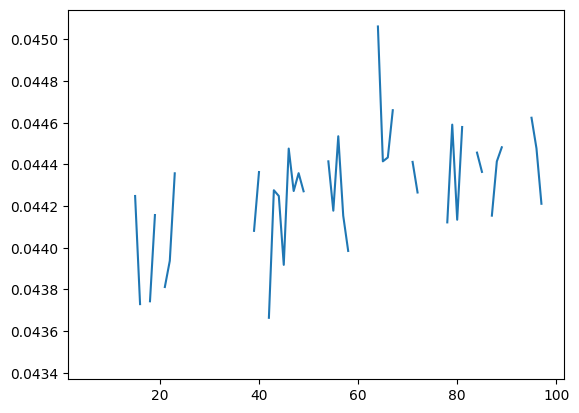

In [53]:
plt.plot(maces)